In [2]:
import math
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


# Technical indicators
from ta.momentum import stochrsi,rsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband, average_true_range
from ta.volume import volume_weighted_average_price, ease_of_movement
# Technical indicators
from modules.Utils.indicators import addIndicators, computeSuperTrend
from modules.Utils.utils import loadFromDB
import warnings 
warnings.filterwarnings('ignore')

from datetime import datetime

In [3]:

def heikinAshiDf(df):
    df['HA_Close'] = (df.Open + df.High + df.Low + df.Close)/4
    ha_open = [(df.Open[0] + df.Close[0]) / 2]
    [ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2)
     for i in range(0, len(df)-1)]
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['HA_Open', 'HA_Close', 'High']].max(axis=1)
    df['HA_Low'] = df[['HA_Open', 'HA_Close', 'Low']].min(axis=1)
    return df


class SuperTrend():
    def __init__(
        self,
        High,
        Low,
        Close,
        atr_window=10,
        atr_multi=3
    ):
        self.High = High
        self.Low = Low
        self.Close = Close
        self.atr_window = atr_window
        self.atr_multi = atr_multi
        self._run()
        
    def _run(self):
        # calculate ATR
        price_diffs = [self.High - self.Low, 
                    self.High - self.Close.shift(), 
                    self.Close.shift() - self.Low]
        true_range = pd.concat(price_diffs, axis=1)
        true_range = true_range.abs().max(axis=1)
        # default ATR calculation in supertrend indicator
        atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
        # atr = ta.volatility.average_true_range(High, Low, Close, atr_period)
        # df['atr'] = df['tr'].rolling(atr_period).mean()
        
        # HL2 is simply the average of High and Low prices
        hl2 = (self.High + self.Low) / 2
        # upperband and lowerband calculation
        # notice that final bands are set to be equal to the respective bands
        final_upperband = upperband = hl2 + (self.atr_multi * atr)
        final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
        
        # initialize Supertrend column to True
        supertrend = [True] * len(self.Close)
        
        for i in range(1, len(self.Close)):
            curr, prev = i, i-1
            
            # if current Close price crosses above upperband
            if self.Close[curr] > final_upperband[prev]:
                supertrend[curr] = True
            # if current Close price crosses below lowerband
            elif self.Close[curr] < final_lowerband[prev]:
                supertrend[curr] = False
            # else, the trend continues
            else:
                supertrend[curr] = supertrend[prev]
                
                # adjustment to the final bands
                if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                    final_lowerband[curr] = final_lowerband[prev]
                if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                    final_upperband[curr] = final_upperband[prev]

            # to remove bands according to the trend direction
            if supertrend[curr] == True:
                final_upperband[curr] = np.nan
            else:
                final_lowerband[curr] = np.nan
                
        self.st = pd.DataFrame({
            'Supertrend': supertrend,
            'Final Lowerband': final_lowerband,
            'Final Upperband': final_upperband
        })
        
    def super_trend_upper(self):
        return self.st['Final Upperband']
        
    def super_trend_lower(self):
        return self.st['Final Lowerband']
        
    def super_trend_direction(self):
        return self.st['Supertrend']
    
    

def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False,heikin_ashi:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.
        heikin_ashi (bool, optional): Add the heikin_ashi candle to the dataframe. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    df['High_Low_diff'] = df.High-df.Low
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['ATR'] = average_true_range(df.High,df.Low,df.Close,22)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    df['OVB'] = (np.sign(df.Close.diff())*df.Volume).fillna(0).cumsum()
    df['OVB_EMA200'] = ema_indicator(df.OVB,200)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if b_engulfings==True:   
        def isBearishCandleStick(candle) -> bool:
            """Check whether a candle is a bearish candle or not

            Args:
                candle (pd.Series): The current candle that contains OHLC

            Returns:
                bool: A boolean representing if the candle is bearish candle (True) or not (False)
            """
            return candle['Close']<candle['Open']

        def isBullishCandleStick(candle) -> bool:
            """Check whether a candle is a bullish candle or not

            Args:
                candle (pd.Series): The current candle that contains OHLC

            Returns:
                bool: A boolean representing if the candle is bullish candle (True) or not (False)
            """
            return candle['Close']>candle['Open']

        def isBullishEngulfing(previous_candle,current_candle) -> int:
            """A function that check for bullish engulfing pattern through candle stick

            Args:
                previous_candle (pd.Series): The previous candle that contains OHLC
                current_candle (pd.Series): The current candle that contains OHLC

            Returns:
                int: represent the pattern spotting : 1 bullish engulfing, 0 not.
            """
            return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
            
        def isBearishEngulfing(previous_candle,current_candle) -> int:
            """A function that check for bearish engulfing pattern through candle stick

            Args:
                previous_candle (pd.Series): The previous candle that contains OHLC
                current_candle (pd.Series): The current candle that contains OHLC

            Returns:
                int: represent the pattern spotting : 1 bearish engulfing, 0 not.
            """
            return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
                
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    if heikin_ashi==True:
        df['HA_Close'] = (df.Open + df.High + df.Low + df.Close)/4
        ha_open = [(df.Open[0] + df.Close[0]) / 2]
        [ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2) for i in range(0, len(df)-1)]
        df['HA_Open'] = ha_open
        df['HA_High'] = df[['HA_Open', 'HA_Close', 'High']].max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close', 'Low']].min(axis=1)
    return df.dropna()



def computeMASlope(df:pd.DataFrame)->pd.DataFrame:
    """Compute MA Slope indicator on a dataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The output dataframe with 2 new columns.
    """
    class MaSlope():
        """ Slope adaptative moving average
        """

        def __init__(
            self,
            Close: pd.Series,
            High: pd.Series,
            Low: pd.Series,
            long_ma: int = 200,
            major_length: int = 14,
            minor_length: int = 6,
            slope_period: int = 34,
            slope_ir: int = 25
        ):
            self.Close = Close
            self.High = High
            self.Low = Low
            self.long_ma = long_ma
            self.major_length = major_length
            self.minor_length = minor_length
            self.slope_period = slope_period
            self.slope_ir = slope_ir
            self._run()

        def _run(self):
            minAlpha = 2 / (self.minor_length + 1)
            majAlpha = 2 / (self.major_length + 1)
            # df = pd.DataFrame(data = [self.Close, self.High, self.Low], columns = ['Close','High','Low'])
            df = pd.DataFrame(data = {"Close": self.Close, "High": self.High, "Low":self.Low})
            df['hh'] = df['High'].rolling(window=self.long_ma+1).max()
            df['ll'] = df['Low'].rolling(window=self.long_ma+1).min()
            df = df.fillna(0)
            df.loc[df['hh'] == df['ll'],'mult'] = 0
            df.loc[df['hh'] != df['ll'],'mult'] = abs(2 * df['Close'] - df['ll'] - df['hh']) / (df['hh'] - df['ll'])
            df['final'] = df['mult'] * (minAlpha - majAlpha) + majAlpha

            ma_first = (df.iloc[0]['final']**2) * df.iloc[0]['Close']

            col_ma = [ma_first]
            for i in range(1, len(df)):
                ma1 = col_ma[i-1]
                col_ma.append(ma1 + (df.iloc[i]['final']**2) * (df.iloc[i]['Close'] - ma1))

            df['ma'] = col_ma
            pi = math.atan(1) * 4
            df['hh1'] = df['High'].rolling(window=self.slope_period).max()
            df['ll1'] = df['Low'].rolling(window=self.slope_period).min()
            df['slope_range'] = self.slope_ir / (df['hh1'] - df['ll1']) * df['ll1']
            df['dt'] = (df['ma'].shift(2) - df['ma']) / df['Close'] * df['slope_range'] 
            df['c'] = (1+df['dt']*df['dt'])**0.5
            df['xangle'] = round(180*np.arccos(1/df['c']) / pi)
            df.loc[df['dt']>0,"xangle"] = - df['xangle']
            self.df = df
            # print(df)

        def ma_line(self) -> pd.Series:
            """ ma_line
                Returns:
                    pd.Series: ma_line
            """
            return self.df['ma']

        def x_angle(self) -> pd.Series:
            """ x_angle
                Returns:
                    pd.Series: x_angle
            """
            return self.df['xangle']
            
        
    ms = MaSlope(df.High, df.Low, df.Close)
    df['Angle'] = ms.x_angle()
    df['MA_Slope'] = ms.ma_line()
    return df

In [3]:
df = loadFromDB('BTC','15m',)
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
len(df)

59370

In [6]:
df = heikinAshiDf(df)
st = SuperTrend(df.High, df.Low, df.Close)
df['super_trend_direction'] = st.super_trend_direction()
df = addIndicators(df)
#df = computeMASlope(df)
df = df.dropna()
df = df.iloc[-1500:]
df.columns

Total records : 1754 rows


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'HA_Close',
       'HA_Open', 'HA_High', 'HA_Low', 'super_trend_direction',
       'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD',
       'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR',
       'CCI', 'OVB', 'OVB_EMA200', 'TRIX', 'TRIX_PCT', 'TRIX_SIGNAL',
       'TRIX_HISTO', 'EVM'],
      dtype='object')

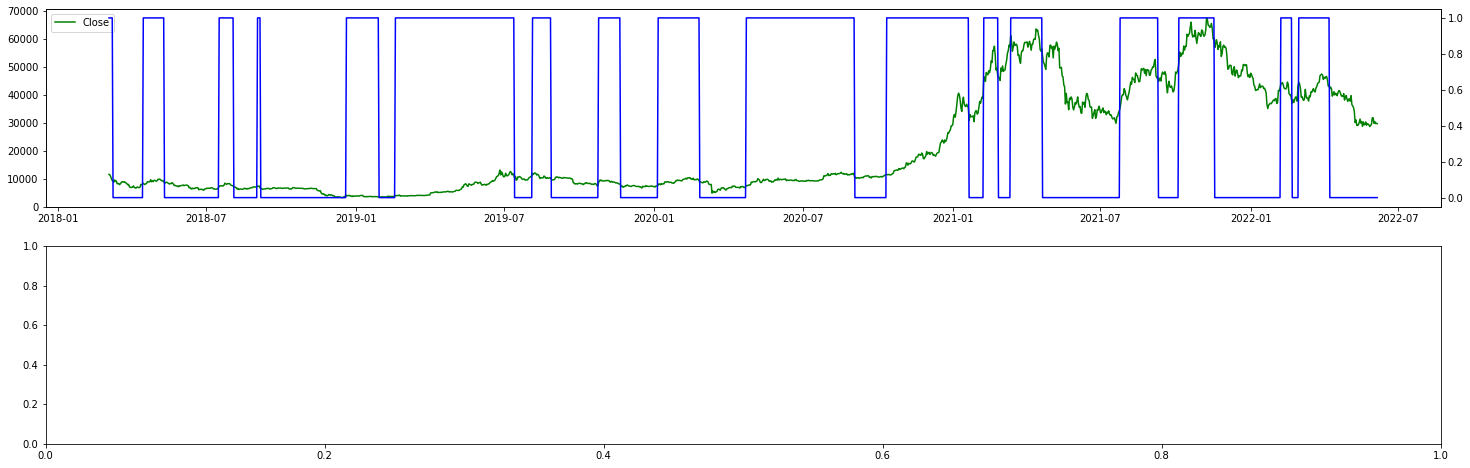

In [7]:
fig, ax_left = plt.subplots(2, figsize=(25,8))

ax_left[0].plot(df.Close, color='green',label='Close')
ax = ax_left[0].twinx()
ax.plot(df.super_trend_direction, color='blue',label='super_trend_direction')
ax_left[0].legend(loc="upper left")

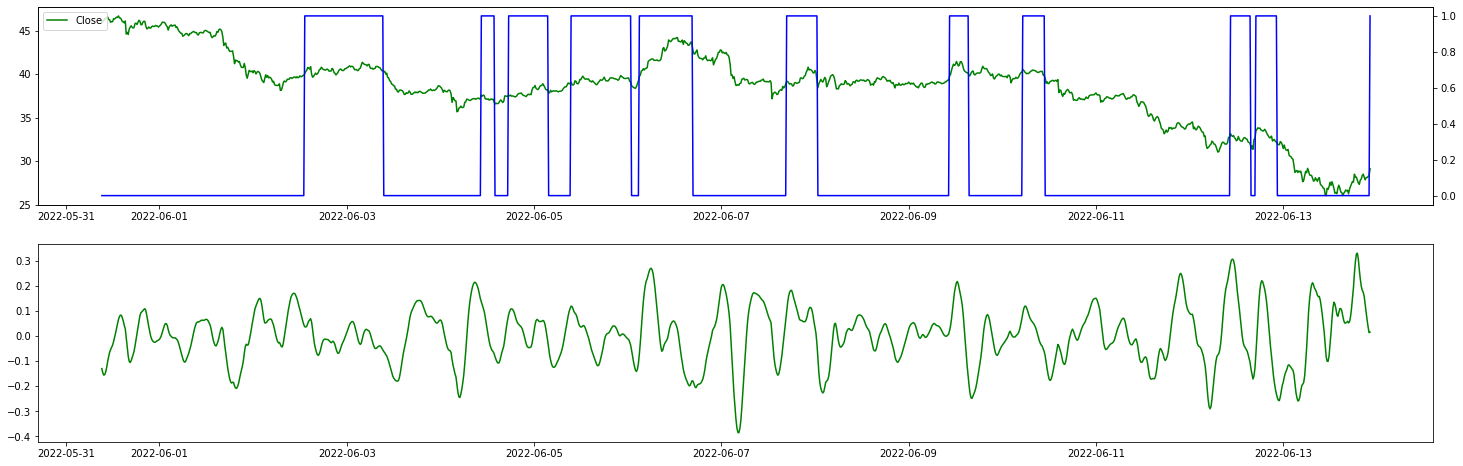

In [15]:
window_to_see = 1500
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(2, figsize=(25,8))

ax_left[0].plot(df_see.Close, color='green',label='Close')
ax = ax_left[0].twinx()
ax.plot(df_see.super_trend_direction, color='blue',label='super_trend_direction')
ax_left[0].legend(loc="upper left")

ax_left[1].plot(df_see.TRIX_HISTO, color='green',label='TRIX_HISTO')

# Trading

In [ ]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]
    else:
        if df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False:
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Change'] = trades['Close'].pct_change()*100
trades_sells = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades_sells.Change.sum())} %")
print(f"Winrate : {round(100*len(trades_sells[trades_sells['Change']>0].Change)/len(trades_sells))} %")
print(f"Total trades : {len(trades)}")
print(f"Average pct {trades_sells.Change.mean()}%")
print(f"Average gain {trades_sells[trades_sells['Change']>0].Change.mean()}%")
print(f"Average loss {trades_sells[trades_sells['Change']<0].Change.mean()}%")
print(f"Total not worthy trade {trades_sells[trades_sells['Change']<0.1]['Change'].count()}")

# Trading future

## Long

In [13]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=True
            last_buy_price  = df['Close'][i]       
    else:
        if df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False:
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Max'] = np.nan
trades['Min'] = np.nan
trades['Enter'] = np.nan
for i in range(1,len(trades)):
    #print(f"from {trades.index[i-1]} to {trades.index[i]}")
    trades.Enter.iloc[i] = trades.iloc[i-1].Close
    trades.Max.iloc[i] = df.loc[trades.index[i-1]:trades.index[i]].High.max()
    trades.Min.iloc[i] = df.loc[trades.index[i-1]:trades.index[i]].Low.min()
    
buys = trades[trades['BUY_SELL']=='SELL']
buys['Max_gain_pct'] =  100*abs(buys['Enter']-buys['Max'])/buys['Enter']
buys['Max_loss_pct'] =  100*abs(buys['Enter']-buys['Min'])/buys['Enter']
print(f"Min max gain {round(buys['Max_gain_pct'].min(),2)} %")
print(f"Average max gain {round(buys['Max_gain_pct'].mean(),2)} %")
print(f"Median max gain {round(buys['Max_gain_pct'].median(),2)} %")
print(f"Standard deviation max gain {round(buys['Max_gain_pct'].std(),2)} %")
print(f"25% quantile {round(buys['Max_gain_pct'].quantile(q=0.40),2)} %")
buys.head()

Min max gain 0.04 %
Average max gain 0.3 %
Median max gain 0.23 %
Standard deviation max gain 0.25 %
25% quantile 0.21 %


,Close,BUY_SELL,Max,Min,Enter,Max_gain_pct,Max_loss_pct
Date,,,,,,,
2022-06-08 19:31:00,1797.18,SELL,1803.92,1798.97,1800.15,0.209427,0.065550
2022-06-08 20:05:00,1799.40,SELL,1805.13,1800.40,1801.24,0.215962,0.046635
2022-06-08 21:07:00,1782.71,SELL,1795.79,1785.07,1785.81,0.558850,0.041438
2022-06-08 21:49:00,1789.81,SELL,1800.29,1794.28,1796.07,0.234957,0.099662
2022-06-08 22:51:00,1797.84,SELL,1805.90,1797.75,1797.40,0.472905,0.019473


### Test long limit

In [7]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=True
            last_buy_price  = df['Close'][i]       
    else:
        if (df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False) or (df.High.iloc[i]>=last_buy_price*1.0025):
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Max'] = np.nan
trades['Enter'] = np.nan
for i in range(1,len(trades)):
    trades.Enter.iloc[i] = trades.iloc[i-1].Close
    trades.Max.iloc[i] = df.loc[trades.index[i-1]:trades.index[i]].High.max()
    
buys = trades[trades['BUY_SELL']=='SELL']
buys['Max_gain_pct'] =  100*abs(buys['Enter']-buys['Max'])/buys['Enter']

print(f"Gain : {round(buys['Max_gain_pct'].sum())} %")
print(f"Winrate : {round(100*len(buys[buys['Max_gain_pct']>0].Max_gain_pct)/len(buys))} %")
print(f"Total trades : {len(buys)}")
print(f"Min max gain {round(buys['Max_gain_pct'].min(),2)} %")
print(f"Average max gain {round(buys['Max_gain_pct'].mean(),2)} %")
print(f"Median max gain {round(buys['Max_gain_pct'].median(),2)} %")
print(f"Standard deviation max gain {round(buys['Max_gain_pct'].std(),2)} %")
print(f"25% quantile {round(buys['Max_gain_pct'].quantile(q=0.40),2)} %")
buys.head()

Gain : 28 %
Winrate : 100 %
Total trades : 20
Min max gain 0.38 %
Average max gain 1.41 %
Median max gain 1.02 %
Standard deviation max gain 0.97 %
25% quantile 0.84 %


,Close,BUY_SELL,Max,Enter,Max_gain_pct
Date,,,,,
2022-05-19 14:00:00,29.18,SELL,29.42,29.27,0.512470
2022-05-20 01:45:00,30.39,SELL,30.60,30.37,0.757326
2022-05-20 11:45:00,30.96,SELL,31.27,31.08,0.611326
2022-05-21 09:30:00,29.66,SELL,29.81,29.65,0.539629
2022-05-22 11:30:00,30.59,SELL,30.62,30.14,1.592568


## Short

In [ ]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False:
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]       
    else:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Max'] = np.nan
trades['Min'] = np.nan
trades['Enter'] = np.nan
trades['Enter_High_Low_diff'] = np.nan
trades['EMA100'] = np.nan
trades['Stoch_RSI'] = np.nan
trades['TRIX'] = np.nan

for i in range(1,len(trades)):
    #print(f"from {trades.index[i-1]} to {trades.index[i]}")
    trades.Enter.iloc[i] = trades.iloc[i-1].Close
    trades.Enter_High_Low_diff.iloc[i] = df.loc[trades.index[i-1]].High_Low_diff
    trades.EMA100.iloc[i] = df.loc[trades.index[i-1]].EMA100
    trades.Stoch_RSI.iloc[i] = df.loc[trades.index[i-1]].Stoch_RSI
    trades.TRIX.iloc[i] = df.loc[trades.index[i-1]].TRIX
    
    trades.Max.iloc[i] = df.loc[trades.index[i-1]:trades.index[i]].High.max()
    trades.Min.iloc[i] = df.loc[trades.index[i-1]:trades.index[i]].Low.min()
    
sells = trades[trades['BUY_SELL']=='BUY']
sells['Max_gain_pct'] =  100*abs(sells['Enter']-sells['Min'])/sells['Enter']
print(f"Min max gain {round(sells['Max_gain_pct'].min(),2)} %")
print(f"Average max gain {round(sells['Max_gain_pct'].mean(),2)} %")
print(f"Median max gain {round(sells['Max_gain_pct'].median(),2)} %")
print(f"Standard deviation max gain {round(sells['Max_gain_pct'].std(),2)} %")
print(f"25% quantile {round(sells['Max_gain_pct'].quantile(q=0.40),2)} %")
sells.head()

['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'HA_Close',
       'HA_Open', 'HA_High', 'HA_Low', 'super_trend_direction',
       'High_Low_diff', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD',
       'Stoch_RSI', 'Vortex', 'Bollinger_low', 'Bollinger_high', 'ADX', 'CCI',
       'OVB', 'OVB_EMA200', 'TRIX', 'TRIX_PCT', 'TRIX_SIGNAL', 'TRIX_HISTO',
       'EVM']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(sells[['Enter_High_Low_diff','EMA100','Stoch_RSI','TRIX']].values, sells.Max_gain_pct.values)
mean_squared_error(model.predict(sells[['Enter_High_Low_diff','EMA100','Stoch_RSI','TRIX']].values),sells.Max_gain_pct,squared=False)

In [ ]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.scatter(model.predict(sells[['Enter_High_Low_diff','EMA100','ADX','TRIX']].values),sells.Max_gain_pct, color='green',label='Close')

In [ ]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]       
    else:
        if df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False:
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]

In [ ]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if df.super_trend_direction.iloc[i-1]==False and  df.super_trend_direction.iloc[i]==True:
            df['BUY_SELL'].iloc[i] = 'BUY'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]       
    else:
        if df.super_trend_direction.iloc[i-1]==True and  df.super_trend_direction.iloc[i]==False:
            df['BUY_SELL'].iloc[i] = 'SELL'
            POSITION_OPENED=False
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Change'] = trades['Close'].pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)*2}")
print(f"Average pct {trades.Change.mean()}%")
print(f"Average gain {trades[trades['Change']>0].Change.mean()}%")
print(f"Average loss {trades[trades['Change']<0].Change.mean()}%")
print(f"Total not worthy trade {trades[trades['Change']<0.1]['Change'].count()}")

In [ ]:

fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df.Close, color='green',label='Close')
ax_left.plot(df.super_trend_upper, color='red',label='super_trend_upper')
ax_left.plot(df.super_trend_lower, color='yellow',label='super_trend_lower')
ax = ax_left.twinx()
ax.plot(df.super_trend_direction, color='blue',label='super_trend_direction')
ax_left.legend(loc="upper left")

# WITH NEWS METHODS

In [2]:
# Technical indicators
from ta.trend import ema_indicator, trix, dpo
from ta.momentum import stochrsi
from ta.volatility import average_true_range
from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope, computeSuperTrend

import pandas as pd

import warnings 
warnings.filterwarnings("ignore")

In [3]:
!ls ../backtest_tools/database/database/KuCoin/1d/

AAVE-USDT.csv	 AVAX-USDT.csv	EGLD-USDT.csv	LINK-USDT.csv	UNI-USDT.csv
ADA-USDT.csv	 AXS-USDT.csv	ETH3L-USDT.csv	MATIC-USDT.csv	XRP-USDT.csv
ALGO-USDT.csv	 BTC-USDT.csv	ETH-USDT.csv	NEAR-USDT.csv
AVAX3L-USDT.csv  DOT-USDT.csv	KDA-USDT.csv	SOL-USDT.csv


In [7]:
SYMBOL= 'LINK'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-08-20 12:00:00,10.0000,16.7359,10.0000,16.6059,1611.784098,1597917600
2020-08-20 13:00:00,16.6057,16.6300,16.3675,16.5112,812.896290,1597921200
2020-08-20 14:00:00,16.5074,16.5074,16.1753,16.3148,1686.695478,1597924800
2020-08-20 15:00:00,16.3143,16.4999,16.2845,16.4369,770.314755,1597928400
2020-08-20 16:00:00,16.4369,16.6300,16.2845,16.5134,622.331476,1597932000


In [8]:
df['EMA']=ema_indicator(close=df['Close'], window=130)
df['STOCH_RSI'] = stochrsi(close=df['Close'], window=14, smooth1=3, smooth2=3)
df = computeSuperTrend(df)
import numpy as np

df_day = loadFromDB(f'../backtest_tools/database/database/KuCoin/1d/{SYMBOL}-USDT.csv')
df_day = computeSuperTrend(df_day)
df_day.dropna(inplace=True)
df_day.tail()
def addST(x):
    try:
        return df_day.loc[pd.to_datetime(x.name).date().strftime("%Y-%m-%d")].ST_Direction.values[0]
    except:
        return np.nan
    
df['ST_day'] = df.apply(addST,axis=1)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Timestamp,EMA,STOCH_RSI,ST_Direction,ST_day
Date,,,,,,,,,,
2020-08-25 21:00:00,14.3163,14.3877,14.1182,14.2938,3544.658633,1598382000,15.248267,0.564061,False,True
2020-08-25 22:00:00,14.2992,14.2993,13.8991,13.9189,2128.480204,1598385600,15.227971,0.339453,False,True
2020-08-25 23:00:00,13.9198,14.1057,13.9198,13.9795,846.402528,1598389200,15.208911,0.401848,False,True
2020-08-26 00:00:00,14.0042,14.3966,14.0042,14.2637,1156.794466,1598392800,15.194480,0.674213,False,True
2020-08-26 01:00:00,14.2643,14.3787,14.1226,14.1391,1619.403486,1598396400,15.178367,0.659258,False,True


Period : [2020-08-25 21:00:00] -> [2022-08-28 23:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 685.04 $
Performance vs US Dollar : -31.5 %
Buy and Hold Performence : -54.81 %
Performance vs Buy and Hold : -42.54 %
Best trade : +40.45 %, the 2021-01-19 21:00:00
Worst trade : -16.47 %, the 2021-04-23 10:00:00
Worst drawBack : -71.0 %
Total fees :  156.46 $

----- Trades Informations -----
Total trades on period : 86
Number of positive trades : 36
Number of negative trades :  50
Trades win rate ratio : 41.86 %
Average trades performance : -0.09 %
Average positive trades : 6.5 %
Average negative trades : -4.83 %

----- Plot -----


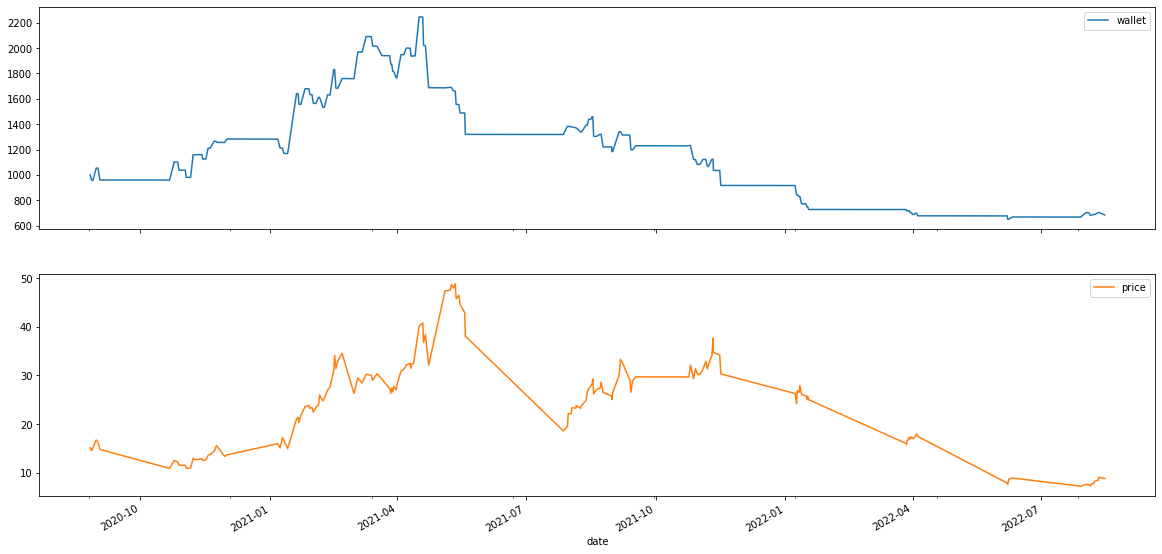

In [9]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['STOCH_RSI']<0.8 and
                    row['ST_Direction']==True and
                    row['ST_day']==True and
                    row['Close']>row['EMA']) else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row['ST_Direction']==False and row['STOCH_RSI']>0.2 else False

strategyTester(df,buyCondition,sellCondition,equity=1000,)

In [100]:
#results=[]
#for j in range(8,20,2):
#    for i in range(50,150,10):
#        SYMBOL= 'AVAX'
#        df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
#        df['EMA']=ema_indicator(close=df['Close'], window=i)
#        df['STOCH_RSI'] = stochrsi(close=df['Close'], window=j, smooth1=3, smooth2=3)
#        df = computeSuperTrend(df)
#        def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
#            return True if (row['STOCH_RSI']<0.8 and row['ST_Direction']==True and row['Close']>row['EMA']) else False
#
#        def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
#            return True if row['ST_Direction']==False and row['STOCH_RSI']>0.2 else False
#
#        coins = strategyTester(df,buyCondition,sellCondition,equity=1000,optimization_process=True)
#        result = {'EMA':i,'STOCH_RSI':j,'coins':coins}
#        print(result)
#        results.append(result)

{'EMA': 50, 'STOCH_RSI': 8, 'coins': 3081.47}
{'EMA': 60, 'STOCH_RSI': 8, 'coins': 4184.31}


KeyboardInterrupt: 